## 3. Дисбаланс выборки

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px

from sklearn import metrics 
from sklearn import model_selection
from sklearn import linear_model
from sklearn import tree


In [2]:
water_data = pd.read_csv("data/water_potability.csv")
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
display(water_data["Potability"].value_counts(normalize=True))

0    0.60989
1    0.39011
Name: Potability, dtype: float64

In [4]:
fig1 = px.histogram(
    data_frame=water_data["Potability"]
)
fig1.show()

## СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется стратифицированным (stratified). Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

In [5]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


In [6]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


**А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?**

Для этого вместо KFold используется кросс-валидатор StratifiedKFold. Принцип работы с ним аналогичен, только, в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

Давайте напишем код, который организует стратифицированное k-fold-разбиение на три фолда, и выведем соотношения классов в каждой из выборок:

In [7]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


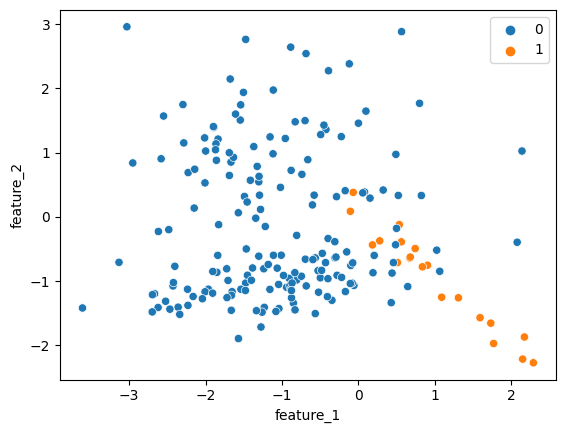

In [8]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);


Train:
0    0.9
1    0.1
dtype: float64
Valid:
0    0.9
1    0.1
dtype: float64


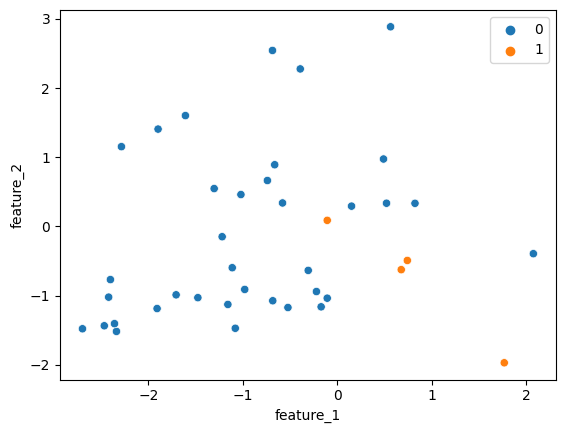

In [9]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y_valid);

## ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Мы поговорили о том, как производить разбиение в условиях дисбаланса классов. Следующий пункт в нашем списке проблем — это использование метрик, которые плохо работают с дисбалансом.

Основной представитель таких метрик — это знакомая нам accuracy, доля угаданных моделью ответов. Вспомним её формулу:

Загвоздка заключается в том, что данная метрика абсолютно не отражает предсказательную способность модели в отношении каждого из классов. В условиях дисбаланса классов данная метрика может дать ложные представления о качестве модели.

Поэтому используются метрики, которые концентрируются на каждом из классов отдельно, — это знакомые нам из модуля по классификации precision, recall и F1-score.

Давайте на примере посмотрим, насколько важен выбор метрики в случае дисбаланса выборки.

Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции classification_report().

In [10]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.50      0.50      0.50         4

    accuracy                           0.90        40
   macro avg       0.72      0.72      0.72        40
weighted avg       0.90      0.90      0.90        40



Из отчёта о метриках классификации видно, что для валидационной выборки метрика accuracy составляет 0.77, что, в принципе, является довольно хорошим результатом. Однако если мы посмотрим на метрики recall и f1-score для каждого из классов в отдельности, мы увидим, что метрики для класса 0 значительно выше, чем метрики для класса 1.

- Precision для класса 1 составляет 0.81, то есть из всех образцов воды, причисленных моделью к классу пригодных для питья, 81 % действительно являются таковыми.
Recall для класса 1 составляет 0.55, то есть из всех образцов в действительности пригодной для питья воды модель посчитала пригодными лишь 55 %, а остальные 45 % посчитала непригодными.
- F1-мера — среднее гармоническое между precision и recall — составила 0.65 для класса 1 и 0.83 — для класса 0. Разница довольно далека от нуля, а значит построенная нами модель больше контролируется на образцах воды, непригодных для питья, и обладает плохой различающей способностью.
- Однако мы не смогли бы выявить этот факт, если бы ориентировались только на метрику accuracy. Одной из причин такого результата является дисбаланс классов: образцов непригодной для питья попросту больше, чем пригодных для питья.

Примечание. Поскольку простая accuracy вызывает сомнения в задачах с сильным дисбалансом, были разработаны специальные метрики, основанные на accuracy: это функционал Каппа Коэна (Cohen’s Kappa) и balanced accuracy. Подробнее о них вы можете прочитать здесь.

In [11]:
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
lr_lstat = linear_model.LogisticRegression()

#Обучаем модель на тренировочной выборке
lr_lstat.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr_lstat.predict(X_train)
y_valid_pred = lr_lstat.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



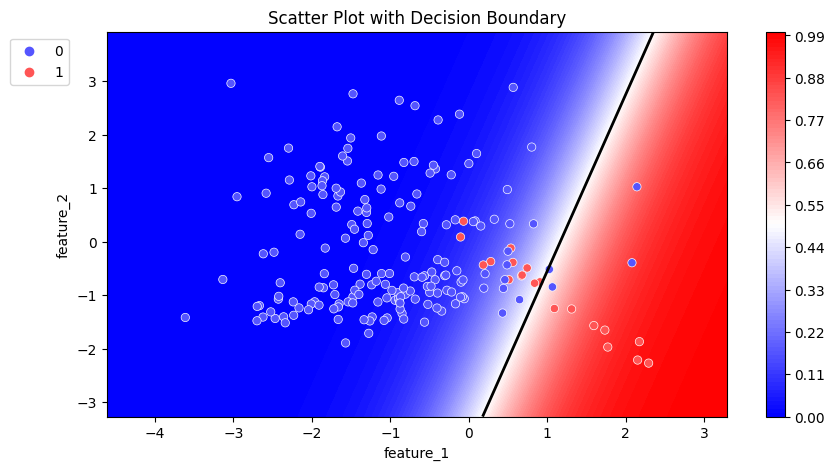

In [12]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
#Теперь вызовем нашу функцию и посмотрим, как логистическая вероятность делит пространство на две части.

plot_probabilities_2d(X, y, lr_lstat)

## ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Итак, мы посмотрели, как дисбаланс выборки может оказывать влияние на способность модели находить класс меньшинства. Но как с этим бороться?

Существует несколько способов уменьшить влияние дисбаланса на обучение модели:

- Взвешивание объектов. В функцию ошибки добавляется штраф, прямо пропорциональный количеству объектов каждого класса. Это очень похоже на регуляризацию, которую мы изучали ранее.
- Выбор порога вероятности. Этот подход мы с вами тоже уже использовали ранее. Он заключается в том, что мы подбираем такой порог вероятности (по умолчанию он равен 0.5 во всех моделях), при котором на валидационной выборке максимизируется целевая метрика (например, -score).
- Сэмплирование (sampling) — перебалансировка выборки искусственным путём:
  - oversampling — искусственное увеличение количества объектов миноритарного класса;
  - undersampling — сокращение количества объектов мажоритарного класса.

  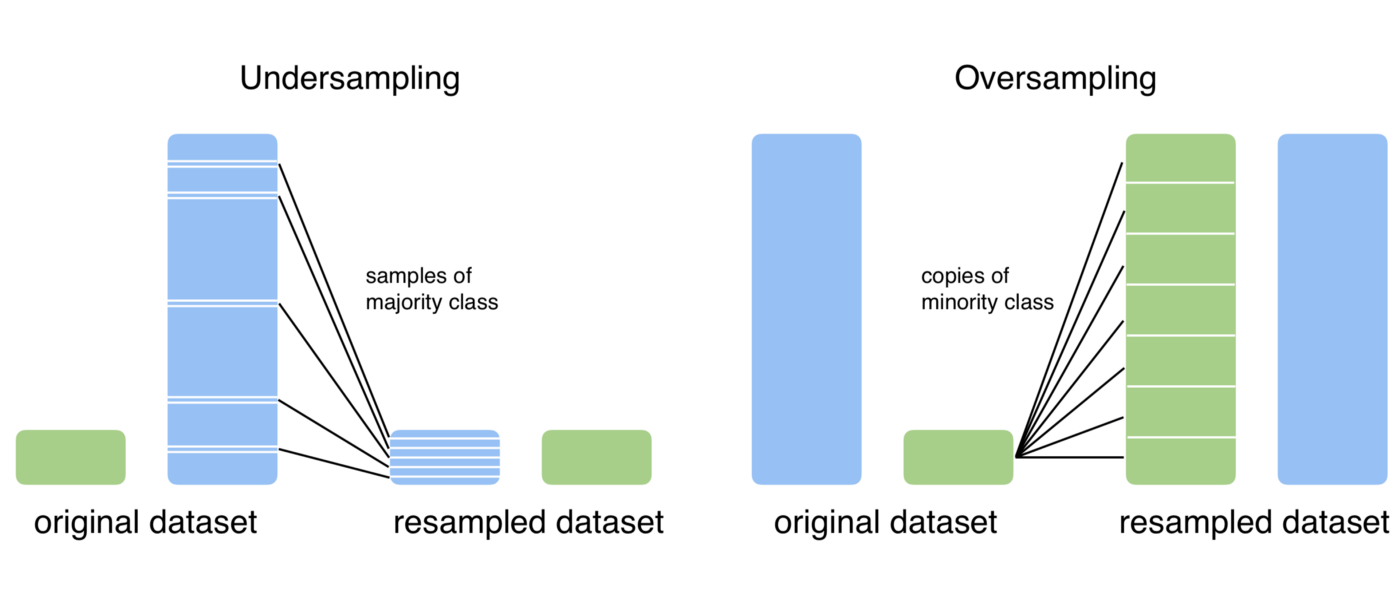

  - Здесь могут использоваться алгоритмы генерации искусственных данных, такие как NearMiss, SMOTE (Synthetic Minority Oversampling Techniques) и ADASYN (Adaptive Synthetic).

## ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Большинство моделей, реализованных в sklearn, имеют параметр class_weight — веса классов. Чтобы сбалансировать важность классов, обычно берут веса объектов класса-большинства (мажоритарного класса) равным

а веса объектов малочисленного (миноритарного) класса вычисляются по следующей формуле:

где minoriry  и mojority число — объектов в миноритарном и мажоритарном классах соответственно. Подобная установка весов заставляет алгоритм обращать большее внимание на объекты менее популярного класса.

Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

Посмотрим на реализацию на примере дерева решений:

In [13]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



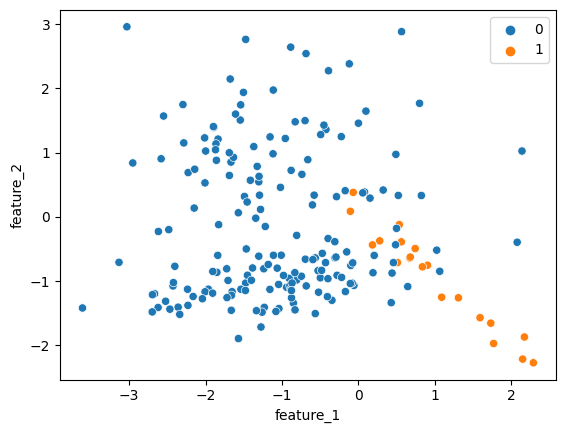

In [14]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

Обучите модель логистической регрессии на тренировочной выборке, установив сбалансированные веса для классов.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [15]:
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
lr_lstat = linear_model.LogisticRegression(class_weight='balanced')

#Обучаем модель на тренировочной выборке
lr_lstat.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr_lstat.predict(X_train)
y_valid_pred = lr_lstat.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



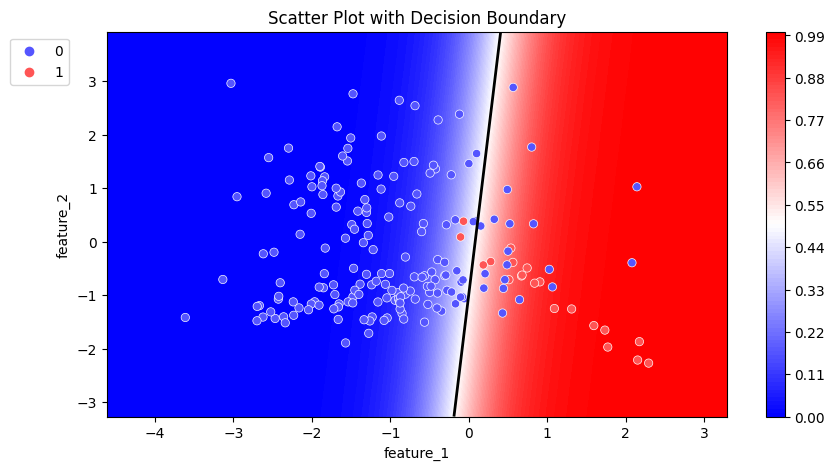

In [16]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
#Теперь вызовем нашу функцию и посмотрим, как логистическая вероятность делит пространство на две части.

plot_probabilities_2d(X, y, lr_lstat)

### PR-кривая (precision-recall curve) — это график зависимости precision от recall при различных значениях порога вероятности.

Подберём порог вероятности с помощью PR-кривой для нашего примера. Так как порог вероятности является внешним параметром модели, будет правильнее подбирать его на кросс-валидации, организованной на тренировочном наборе данных, а итоговое качество оценивать на отложенной выборке.

Пусть мы хотим найти такой порог вероятности, при котором наблюдается максимум метрики  для класса 1 (питьевая вода).

Перед построением PR-кривой нам необходимо предсказать вероятность принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции cross_validate().

In [17]:
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


In [18]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

In [19]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [20]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Best threshold = 0.33, F1-Score = 0.69


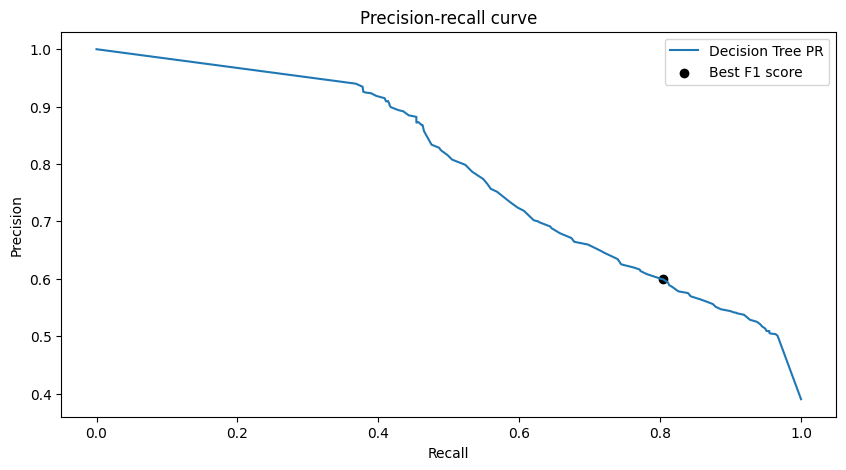

In [21]:
#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [22]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.33
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



In [23]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.79


## СЭМПЛИРОВАНИЕ

Следующий подход работы в условиях дисбаланса классов, который мы рассмотрим, — сэмплирование, а точнее — пересэмплирование (oversampling).

Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.

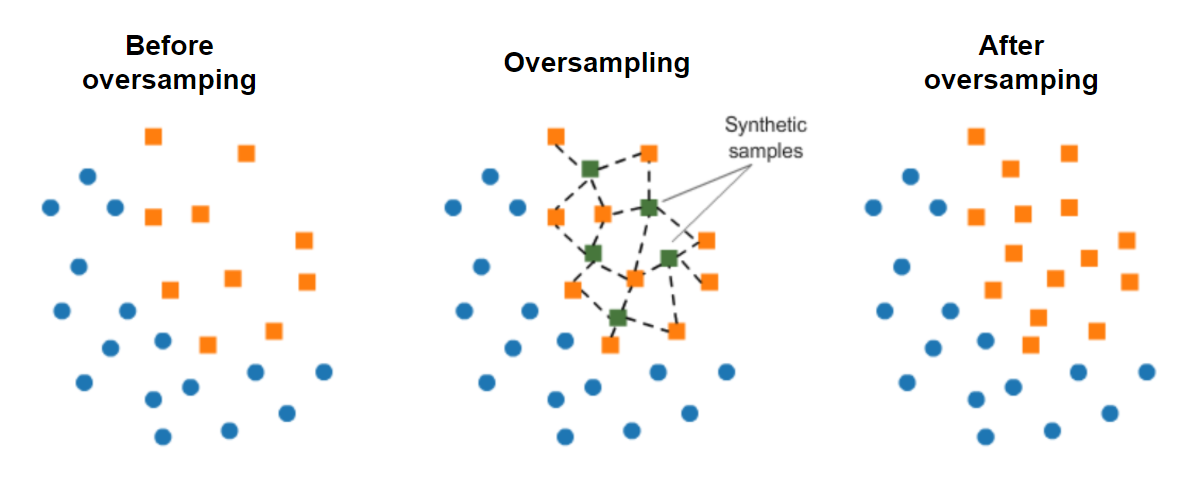

Простейшая стратегия пересэмплирования — продублировать объекты малого класса. Но это неинтересно и работает довольно плохо. Поэтому были созданы специальные алгоритмы генерации искусственных данных. Самый популярный из таких алгоритмов — алгоритм SMOTE (Synthetic Minority Oversampling Techniques).

В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы «похожи» на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировали их.

Мы не будем сейчас заострять внимание на математической работе алгоритма, и вместо этого посмотрим на 2D-анимацию работы данного метода:

In [25]:
from imblearn.over_sampling import SMOTE # импортируем клас смоуте
sm = SMOTE(random_state=2)#объявляем класс
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)# достраиваем данные

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')


Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
0    1598
1    1022
Name: Potability, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
0    1598
1    1598
Name: Potability, dtype: int64


In [26]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



Сбалансируйте тренировочную выборку с помощью алгоритма SMOTE. В качестве значения параметра random_state возьмите число 42, остальные параметры оставьте по умолчанию.

Обучите модель логистической регрессии на пересэмплированной тренировочной выборке. Все параметры оставьте по умолчанию.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

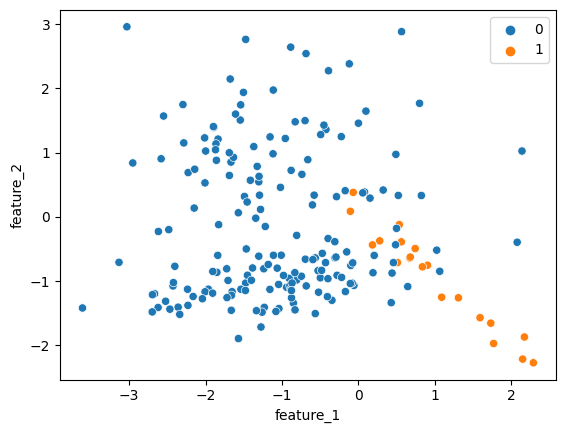

In [32]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [33]:
from imblearn.over_sampling import SMOTE # импортируем клас смоуте
sm = SMOTE(random_state=2)#объявляем класс
X_train_s, y_train_s = sm.fit_resample(X, y)# достраиваем данные

print('Train shape before oversampling:', X.shape) 
print('Class balance before oversampling: \n', y.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (200, 2)
Class balance before oversampling: 
0    180
1     20
dtype: int64
----------------------------------------
Train shape after oversampling: (360, 2)
Class balance after oversampling: 
0    180
1    180
dtype: int64


In [35]:
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
lr_lstat = linear_model.LogisticRegression(class_weight='balanced')

#Обучаем модель на тренировочной выборке
lr_lstat.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = lr_lstat.predict(X_train_s)
y_valid_pred = lr_lstat.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



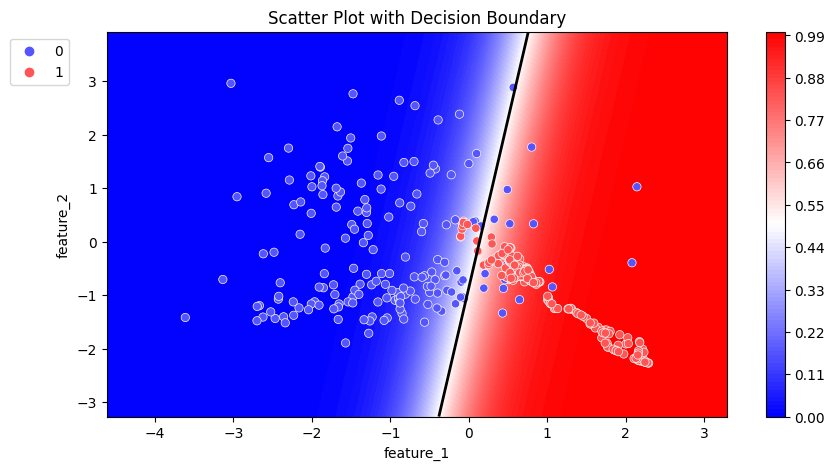

In [37]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
#Теперь вызовем нашу функцию и посмотрим, как логистическая вероятность делит пространство на две части.

plot_probabilities_2d(X_train_s, y_train_s, lr_lstat)